# Trabajo Práctico 2

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import fftpack

 # para que me imprima el graico en la misma notebook
%matplotlib inline

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para 
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada 
de Fourier

In [11]:
def create_gauss_filter(h, w, k_size=15, sigma=2):
    """
    Crea un kernel Gaussiano y su Transformada de Fourier.

    Parámetros:
    - h: Altura de la imagen
    - w: Ancho de la imagen
    - k_size: Tamaño del kernel (debe ser impar)
    - sigma: Desviación estándar de la distribución Gaussiana

    Retorna:
    - kernel: Kernel Gaussiano del mismo tamaño que la imagen con padding aplicado
    - kernel_tf: Transformada de Fourier del kernel Gaussiano
    """
    # Crear un kernel Gaussiano unidimensional y multiplicarlo por la traspuesta para obtener el 2D.
    gauss_kernel_1d = cv.getGaussianKernel(k_size, sigma)
    gauss_kernel_2d = gauss_kernel_1d * gauss_kernel_1d.T

    # Crear una imagen vacía del tamaño deseado y ubica al kernel en el centro
    kernel = np.zeros((h, w), dtype=np.float32)
    kh, kw = gauss_kernel_2d.shape
    kernel[(h - kh) // 2:(h - kh) // 2 + kh, (w - kw) // 2:(w - kw) // 2 + kw] = gauss_kernel_2d

    # Calcular la Transformada de Fourier del kernel
    kernel_tf = np.fft.fft2(kernel)

    return kernel, kernel_tf

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una 
imagen para validar el funcionamiento en el dominio espectral. 


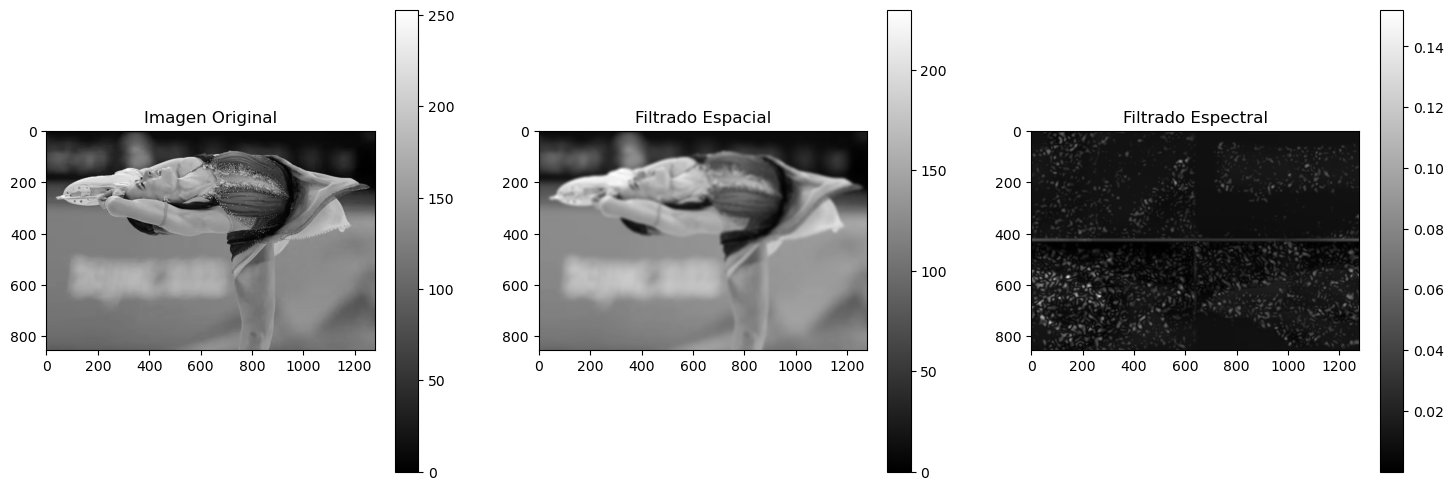

In [42]:
img_path = 'patin.png' 
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

if img is None:
    raise ValueError("No se pudo cargar la imagen.")

h, w = img.shape
k_size = 21
sigma = 5

# filtro gaussiano y su FFT
gauss_filter, gauss_filter_fft = create_gauss_filter(h, w, k_size, sigma)

# Filtrado en dominio espacial
filtered_img_spatial = cv.filter2D(img, -1, gauss_filter)

# Filtrado en dominio de la frecuencia
img_fft = fftpack.fft2(img)
img_fft_shifted = fftpack.fftshift(img_fft)
filtered_img_fft = img_fft_shifted * gauss_filter_fft
filtered_img_spectral = np.abs(fftpack.ifft2(fftpack.ifftshift(filtered_img_fft)))

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('Filtrado Espacial')
plt.imshow(filtered_img_spatial, cmap='gray')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Filtrado Espectral')
plt.imshow(filtered_img_spectral, cmap='gray')
plt.colorbar()

plt.show()

2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency 
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [54]:
# Medir la nitidez de la imagen, algoritmo descripto en el paper.
def measure_sharpness(img):
    
    F = fftpack.fft2(img) # tf de la img
    Fc = fftpack.fftshift(F) # desplaza el origen al centro
    AF = np.abs(Fc) 
    M = np.max(AF) # maximo valor
    thres = M / 1000 # umbral thres = M / 1000
    TH = np.sum(AF > thres) # cuenta el número de píxeles en AF que superan el umbral thres
    FM = TH / (img.shape[0] * img.shape[1]) # calcula la medida de nitidez
    return AF, FM  # retorna los valores de la FFT (ndarray) y la medida de nitidez (float)

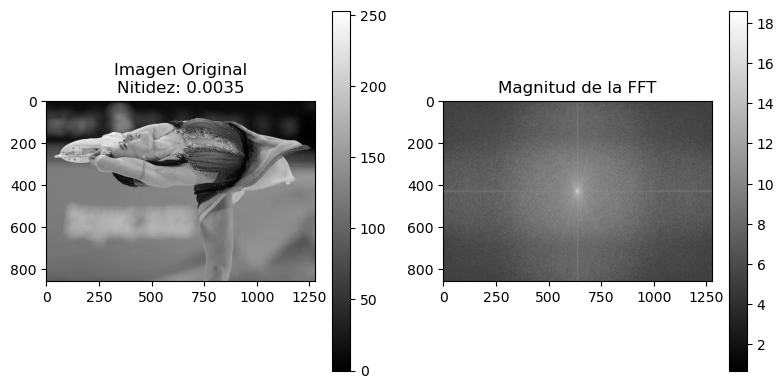

In [56]:
# Calcular la nitidez de la imagen original
AF_original, measure_sharpness_filtered_original = measure_sharpness(img)

# Mostrar imagen original y su medida de nitidez
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title(f'Imagen Original\nNitidez: {measure_sharpness_filtered_original:.4f}')
plt.imshow(img, cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Magnitud de la FFT')
plt.imshow(np.log(AF_original + 1), cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


Nitidez de la imagen original (FFT): 0.0035
Nitidez de la imagen filtrada (espacial FFT): 0.0000
Nitidez de la imagen filtrada (espectral FFT): 0.0035


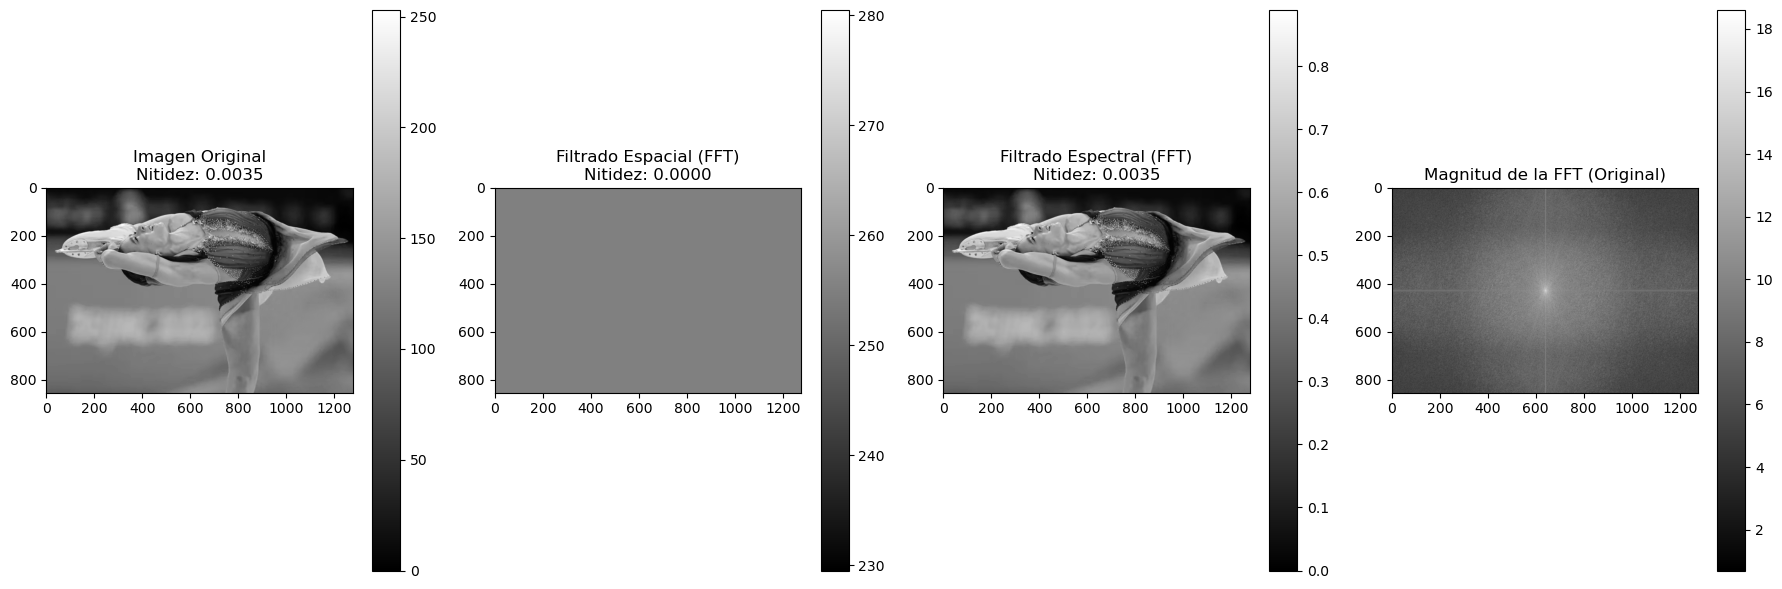

In [51]:
# Filtrado espacial y espectral para medida de nitidez usando FFT
AF_original, measure_sharpness_filtered_original = measure_sharpness(img)
img_fft = fftpack.fft2(img)
img_fft_shifted = fftpack.fftshift(img_fft)
filtered_img_fft = img_fft_shifted * measure_sharpness_filtered_original
filtered_img_spectral = np.abs(fftpack.ifft2(fftpack.ifftshift(filtered_img_fft)))

# Filtrado espacial para medida de nitidez usando FFT
filtered_img_spatial = cv.filter2D(img, -1, np.real(fftpack.ifft2(fftpack.ifftshift(AF_original))))

# Calcular la nitidez de las imágenes filtradas
AF_spatial, measure_sharpness_filtered_spatial = measure_sharpness(filtered_img_spatial)
AF_spectral, measure_sharpness_filtered_spectral = measure_sharpness(filtered_img_spectral)

print(f'Nitidez de la imagen original (FFT): {measure_sharpness_filtered_original:.4f}')
print(f'Nitidez de la imagen filtrada (espacial FFT): {measure_sharpness_filtered_spatial:.4f}')
print(f'Nitidez de la imagen filtrada (espectral FFT): {measure_sharpness_filtered_spectral:.4f}')

# Mostrar imágenes y sus respectivas medidas de nitidez
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.title(f'Imagen Original\nNitidez: {measure_sharpness_filtered_original:.4f}')
plt.imshow(img, cmap='gray')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.title(f'Filtrado Espacial (FFT)\nNitidez: {measure_sharpness_filtered_spatial:.4f}')
plt.imshow(filtered_img_spatial, cmap='gray')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.title(f'Filtrado Espectral (FFT)\nNitidez: {measure_sharpness_filtered_spectral:.4f}')
plt.imshow(filtered_img_spectral, cmap='gray')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.title('Magnitud de la FFT (Original)')
plt.imshow(np.log(AF_original + 1), cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of 
focus measure operators in shape-from-focus”

Tenengrad de la imagen original: 17.6551339610821
Tenengrad de la imagen filtrada (espacial): 198.07458896787622
Tenengrad de la imagen filtrada (espectral): 28133629978473.234


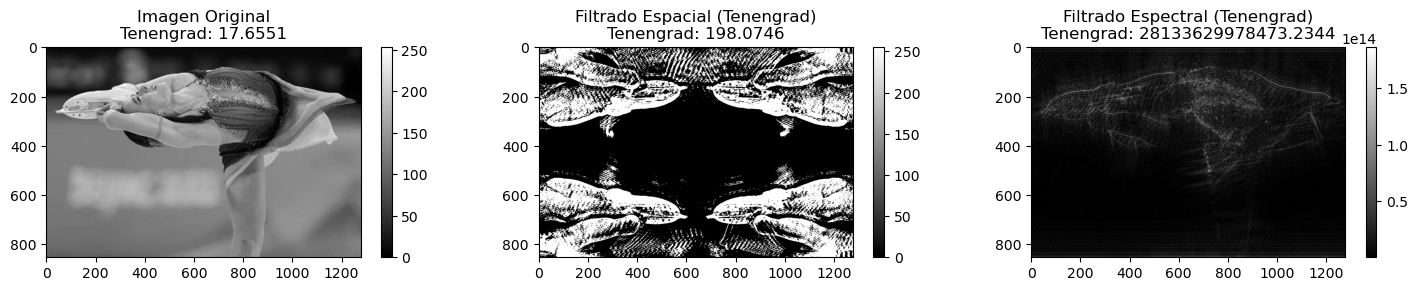

In [44]:
def tenengrad_focus_measure(img, ksize=3): # Tenegrad es uno de los métodos descriptos en el paper.
    """
    Calcula la medida de enfoque Tenengrad de una imagen.
    
    Parámetros:
    img (ndarray): Imagen de entrada.
    ksize (int): Tamaño del kernel Sobel.
    
    Retorna:
    float: Medida de enfoque Tenengrad.
    """
    Gx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=ksize)
    Gy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=ksize)
    FM = np.sqrt(Gx**2 + Gy**2)
    return np.mean(FM)

# Filtrado espacial y espectral para Tenengrad
tenengrad_original = tenengrad_focus_measure(img)
Gx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=k_size)
Gy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=k_size)
FM_tenengrad = np.sqrt(Gx**2 + Gy**2)
filtered_img_spatial_tenengrad = cv.filter2D(img, -1, np.real(fftpack.ifft2(fftpack.ifftshift(FM_tenengrad))))
img_fft = fftpack.fft2(img)
img_fft_shifted = fftpack.fftshift(img_fft)
filtered_img_fft_tenengrad = img_fft_shifted * FM_tenengrad
filtered_img_spectral_tenengrad = np.abs(fftpack.ifft2(fftpack.ifftshift(filtered_img_fft_tenengrad)))

# nitidez de las imágenes filtradas usando Tenengrad
tenengrad_spatial = tenengrad_focus_measure(filtered_img_spatial_tenengrad)
tenengrad_spectral = tenengrad_focus_measure(filtered_img_spectral_tenengrad)

print(f'Tenengrad de la imagen original: {tenengrad_original}')
print(f'Tenengrad de la imagen filtrada (espacial): {tenengrad_spatial}')
print(f'Tenengrad de la imagen filtrada (espectral): {tenengrad_spectral}')

plt.figure(figsize=(18, 6))

plt.subplot(2, 3, 1)
plt.title(f'Imagen Original\nTenengrad: {tenengrad_original:.4f}')
plt.imshow(img, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.title(f'Filtrado Espacial (Tenengrad)\nTenengrad: {tenengrad_spatial:.4f}')
plt.imshow(filtered_img_spatial_tenengrad, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.title(f'Filtrado Espectral (Tenengrad)\nTenengrad: {tenengrad_spectral:.4f}')
plt.imshow(filtered_img_spectral_tenengrad, cmap='gray')
plt.colorbar()
plt.show()

In [40]:
def laplacian_variance_focus_measure(img, ksize=3):
    """
    Calcula la medida de enfoque Laplacian Variance de una imagen.
    
    Parámetros:
    img (ndarray): Imagen de entrada.
    ksize (int): Tamaño del kernel Laplaciano.
    
    Retorna:
    float: Medida de enfoque Laplacian Variance.
    """
    laplacian = cv.Laplacian(img, cv.CV_64F, ksize=ksize)
    FM = np.var(laplacian)
    return FM


Laplacian Variance de la imagen original: 937.279201579263
Laplacian Variance de la imagen filtrada (espacial): 405742.46976546914
Laplacian Variance de la imagen filtrada (espectral): 5.705684825159518e+25


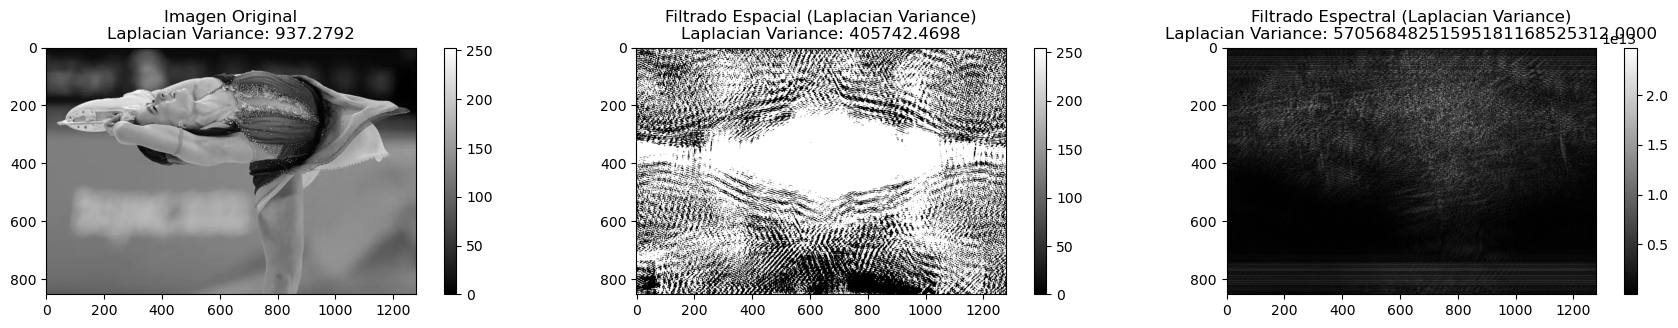

In [45]:
# Filtrado espacial y espectral para Laplacian Variance
laplacian_original = laplacian_variance_focus_measure(img)
laplacian = cv.Laplacian(img, cv.CV_64F, ksize=k_size)
FM_laplacian = np.var(laplacian)
filtered_img_spatial_laplacian = cv.filter2D(img, -1, np.real(fftpack.ifft2(fftpack.ifftshift(laplacian))))
filtered_img_fft_laplacian = img_fft_shifted * laplacian
filtered_img_spectral_laplacian = np.abs(fftpack.ifft2(fftpack.ifftshift(filtered_img_fft_laplacian)))

# nitidez de las imágenes filtradas usando Laplacian Variance
laplacian_spatial = laplacian_variance_focus_measure(filtered_img_spatial_laplacian)
laplacian_spectral = laplacian_variance_focus_measure(filtered_img_spectral_laplacian)

print(f'Laplacian Variance de la imagen original: {laplacian_original}')
print(f'Laplacian Variance de la imagen filtrada (espacial): {laplacian_spatial}')
print(f'Laplacian Variance de la imagen filtrada (espectral): {laplacian_spectral}')

plt.figure(figsize=(18, 6))

plt.subplot(2, 3, 4)
plt.title(f'Imagen Original\nLaplacian Variance: {laplacian_original:.4f}')
plt.imshow(img, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title(f'Filtrado Espacial (Laplacian Variance)\nLaplacian Variance: {laplacian_spatial:.4f}')
plt.imshow(filtered_img_spatial_laplacian, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title(f'Filtrado Espectral (Laplacian Variance)\nLaplacian Variance: {laplacian_spectral:.4f}')
plt.imshow(filtered_img_spectral_laplacian, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()